In [1]:
import os
os.environ["PYTORCH_JIT_USE_NNC_NOT_NVFUSER"] = "1"

In [2]:
from typing import List, Tuple, Optional, Union, Iterable

import plotly.graph_objects as go

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from diffusion_edf.transforms import quaternion_apply, random_quaternions, quaternion_multiply, quaternion_invert, axis_angle_to_quaternion, se3_exp_map, matrix_to_quaternion, se3_log_map

from e3nn import o3

from diffusion_edf.embedding import NodeEmbeddingNetwork
from diffusion_edf.data import SE3, PointCloud, TargetPoseDemo, DemoSequence, DemoSeqDataset, load_demos, save_demos
from diffusion_edf.preprocess import Rescale, NormalizeColor, Downsample, PointJitter, ColorJitter
from diffusion_edf.wigner import TransformFeatureQuaternion
from diffusion_edf.score_model import ScoreModel

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
unit_len = 0.01
scene_voxel_size = 0.01
grasp_voxel_size = 0.01

scene_voxel_size = scene_voxel_size / unit_len
grasp_voxel_size = grasp_voxel_size / unit_len


rescale_fn = Rescale(rescale_factor=1/unit_len)
recover_scale_fn = Rescale(rescale_factor=unit_len)
normalize_color_fn = NormalizeColor(color_mean = torch.tensor([0.5, 0.5, 0.5]), color_std = torch.tensor([0.5, 0.5, 0.5]))
recover_color_fn = NormalizeColor(color_mean = -normalize_color_fn.color_mean / normalize_color_fn.color_std, color_std = 1 / normalize_color_fn.color_std)


scene_proc_fn = Compose([rescale_fn,
                         Downsample(voxel_size=scene_voxel_size, coord_reduction="average"),
                         normalize_color_fn])
scene_unproc_fn = Compose([recover_color_fn, recover_scale_fn])
grasp_proc_fn = Compose([rescale_fn,
                         Downsample(voxel_size=grasp_voxel_size, coord_reduction="average"),
                         normalize_color_fn])
grasp_unproc_fn = Compose([recover_color_fn, recover_scale_fn])

In [4]:
import math

device = 'cuda:0'
compile = False
eval = True

irreps_input = o3.Irreps('3x0e')
irreps_node_embedding = o3.Irreps('32x0e+16x1e+8x2e') #o3.Irreps('128x0e+64x1e+32x2e')
irreps_sh = o3.Irreps('1x0e+1x1e+1x2e')
fc_neurons = [128, 64, 64]
num_heads = 4
alpha_drop = 0.2
proj_drop = 0.0
drop_path_rate = 0.0
irreps_mlp_mid = 2
n_scales = 4
pool_ratio = 0.5

In [5]:
score_model = ScoreModel(irreps_input = irreps_input,
                         irreps_emb_init = irreps_node_embedding,
                         irreps_sh = irreps_sh,
                         fc_neurons_init = [32, 16, 16],
                         num_heads = 4,
                         n_scales = 4,
                         pool_ratio = 0.5,
                         dim_mult = [1, 2, 3, 4],
                         n_layers = 2,
                         gnn_radius = 2.0,
                         cutoff_radius = 3.0,
                         weight_feature_dim = 20,
                         query_downsample_ratio = 0.3,
                         device=device,
                         deterministic = True,
                         compile_head = compile)

score_model = score_model.to(device)
if eval:
    score_model = score_model.eval()

/home/hw/anaconda3/envs/diff_edf/lib/python3.8/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


# Load demo

In [6]:
optimizer = torch.optim.Adam(list(score_model.parameters()), lr=1e-4, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)

In [7]:
loss_fn = torch.nn.MSELoss(reduction='mean')

In [8]:
trainset = DemoSeqDataset(dataset_dir="demo/test_demo", annotation_file="data.yaml", device=device)
train_dataloader = DataLoader(trainset, shuffle=True, collate_fn=lambda x:x)

In [9]:
loss_list = []

In [10]:
optimizer.zero_grad(set_to_none=True)

In [11]:
std_ang = 0.5
std_lin = 1.0

In [12]:
max_epochs = 100
N_samples = 10

iter = 0
for epoch in range(1, max_epochs+1):
    for train_batch in train_dataloader:
        iter += 1
        assert len(train_batch) == 1, "Batch training is not supported yet."

        optimizer.zero_grad()

        demo_seq: DemoSequence = train_batch[0]
        demo: TargetPoseDemo = demo_seq[1]

        scene_raw: PointCloud = demo.scene_pc
        grasp_raw: PointCloud = demo.grasp_pc
        target_poses: SE3 = demo.target_poses

        scene_proc = scene_proc_fn(scene_raw).to(device)
        grasp_proc = grasp_proc_fn(grasp_raw).to(device)
        target_poses = rescale_fn(target_poses).to(device)

        T_target = target_poses.poses

        disp_q = torch.randn(N_samples, 3, device=device) * std_ang
        disp_x = torch.randn(N_samples, 3, device=device) * std_lin
        disp_T = se3_exp_map(torch.cat([disp_x, disp_q], dim=-1))
        disp_T = torch.cat([matrix_to_quaternion(disp_T[...,:3,:3]), disp_T[...,:3,-1]], dim=-1)


        T = torch.cat([quaternion_multiply(T_target[..., :4], disp_T[..., :4]), 
                    quaternion_apply(T_target[..., :4], disp_T[..., 4:]) + T_target[..., 4:]], dim=-1)


        key_feature = scene_proc.colors
        key_coord = scene_proc.points
        key_batch = torch.zeros(len(key_coord), device=device, dtype=torch.long)
        query_feature = grasp_proc.colors
        query_coord = grasp_proc.points
        query_batch = torch.zeros(len(query_coord), device=device, dtype=torch.long)

        score, query_info, key_info = score_model(T=T,
                                                  key_feature=key_feature, key_coord=key_coord, key_batch=key_batch,
                                                  query_feature=query_feature, query_coord=query_coord, query_batch=query_batch,
                                                  info_mode='NONE')
        
        loss = loss_fn(score, -torch.cat([disp_q/std_ang, disp_x/std_lin], dim=-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    print(torch.tensor(loss_list[-len(trainset):]).mean())

tensor(1.0980)
tensor(0.9636)
tensor(0.9553)
tensor(0.9565)
tensor(0.8309)
tensor(0.8617)
tensor(0.9896)
tensor(0.8714)
tensor(0.8592)
tensor(0.8587)
tensor(0.9315)
tensor(0.9037)
tensor(0.8276)
tensor(0.9038)
tensor(0.8701)
tensor(0.9444)
tensor(0.8722)
tensor(0.8857)
tensor(0.9131)
tensor(0.8992)
tensor(0.8459)
tensor(0.7602)
tensor(0.8090)
tensor(0.9047)
tensor(0.9084)
tensor(0.7524)
tensor(0.8799)
tensor(0.8450)
tensor(0.7976)
tensor(0.7830)
tensor(0.8247)
tensor(0.8701)
tensor(0.8746)
tensor(0.8111)
tensor(0.8521)
tensor(0.8657)
tensor(0.8718)
tensor(0.9119)
tensor(0.7803)
tensor(0.9780)
tensor(0.9485)
tensor(0.8453)
tensor(0.8875)
tensor(0.8283)
tensor(0.8815)
tensor(0.8070)
tensor(0.8717)
tensor(0.7448)
tensor(0.8416)
tensor(0.8039)
tensor(0.7880)
tensor(0.8170)
tensor(0.7834)
tensor(0.9160)
tensor(0.8671)
tensor(0.8036)
tensor(0.7411)
tensor(0.9098)
tensor(0.7530)
tensor(0.8025)
tensor(0.8954)
tensor(0.8500)
tensor(0.8627)
tensor(0.8831)
tensor(0.8118)
tensor(0.9141)
tensor(0.8

KeyboardInterrupt: 

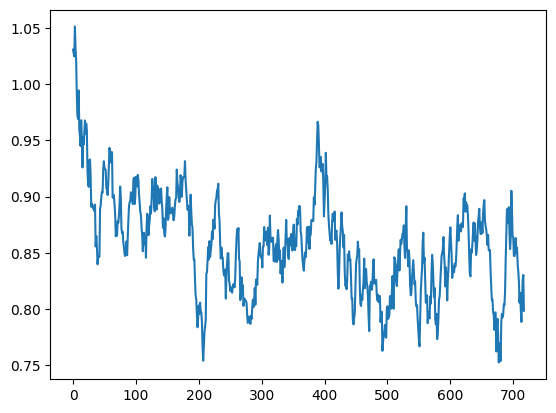

In [29]:
import matplotlib.pyplot as plt
ll = torch.tensor(loss_list)
window_len = 20
ll_filtered = ll.unfold(0, window_len, 1).mean(dim=-1)
plt.plot(ll_filtered)